<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа»</b></h3>


## Импорт Библиотек

In [213]:
import numpy as np
import pandas as pd

import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Импорт данных

In [214]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape, '\n',data.dtypes)

Размеры датасета (6000, 9) 
 was_married      int64
children       float64
salary         float64
sex              int64
age            float64
profession      object
home_cost      float64
drive_info     float64
happyness      float64
dtype: object


In [215]:
data.describe()

,was_married,children,salary,sex,age,home_cost,drive_info,happyness
count,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6.000000e+03,3230.000000,6000.000000
mean,0.842000,2.887167,8.463445e+07,0.661833,31.776667,1.019184e+07,0.729102,0.460160
std,0.364771,2.850285,8.022130e+07,0.473125,32.546372,3.120066e+05,0.444492,0.153727
min,0.000000,0.000000,1.765712e+06,0.000000,2.000000,9.824378e+06,0.000000,0.000000
25%,1.000000,1.000000,1.092669e+07,0.000000,10.000000,1.009639e+07,0.000000,0.351787
50%,1.000000,2.000000,4.301600e+07,1.000000,17.000000,1.017716e+07,1.000000,0.451588
75%,1.000000,4.000000,1.588318e+08,1.000000,32.000000,1.026920e+07,1.000000,0.562556
max,1.000000,9.000000,3.459271e+08,1.000000,100.000000,2.065792e+07,1.000000,1.000000


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

In [216]:
data['children'] = data['children'].astype('int64') # меняем на int32 т.к. кол-во детей целое число
data['age'] = data['age'].astype('int64') # меняем на int32 т.к. возраст целое число

<div class="alert alert-info">
<b>Задание</b>

##<font color='darkblue'>
* 1.Изучить датасет, выполнить задания и проверить некоторые гипотезы, предложенные ниже, используя только визуализацию.
</font>

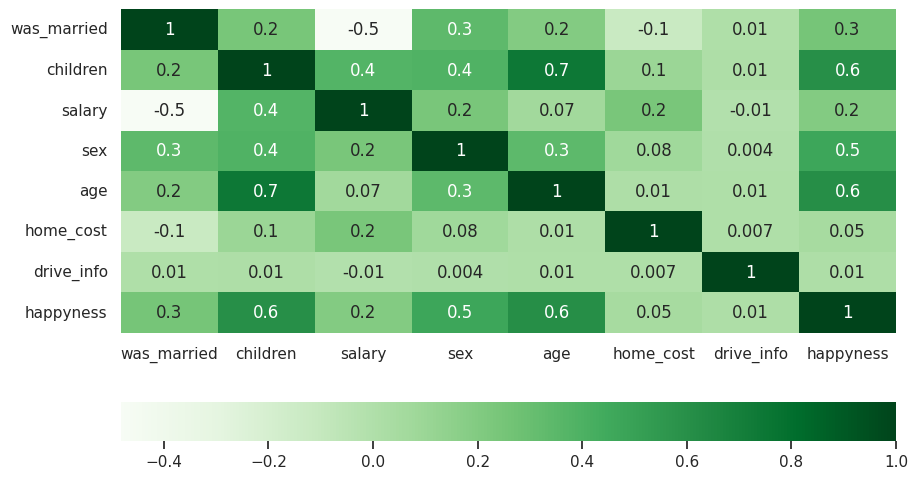

In [217]:
plt.figure(figsize = (10,6))
data_heatmap = data.drop('profession', axis=1, inplace = False)
#create heatmap
sns.heatmap(data_heatmap.corr(), annot=True, fmt='.1g', cbar_kws= {'orientation': 'horizontal'}, cmap = 'Greens');

# <font color='darkblue'>Чистка датасета
</font>

##<font color='darkblue'>
* 2.1.Есть ли дубли в данных? Если есть - удалите их (drop_duplicates).
* 2.2.Найти и удалить/отфильтровать выбросы по признаку `home_cost`. Таких точек около 5
</font>



Всего данных: 51230


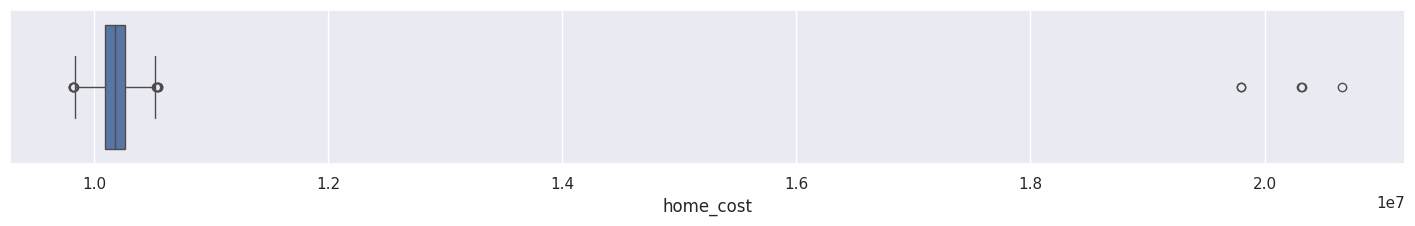

In [218]:
plt.figure(figsize=(18, 2))
sns.boxplot(data['home_cost'], orient='h');
print ('Всего данных:', data.notnull().sum().sum())

In [219]:
#Удаление выбросов методом межквартильного диапазона:
#определение Q1, Q3, interquartile range, порог экстрем. значений выбросов (для метода интерквартильных расстояний выбросы: значения, превышающие 1.5 IQR, а экстремальные значения - превышающие значение 3 IQR)
Q1 = data['home_cost'].quantile(q = .25)
Q3 = data['home_cost'].quantile(q = .75)
IQR = Q3 - Q1
N_extreme = 3 #N_standart = 1.5

#новый датафрейм без выбросов
data_clean = data[(data['home_cost'] < (Q3 + N_extreme * IQR)) & (data['home_cost'] > (Q1 - N_extreme * IQR))]
outliers1 = data[~((data['home_cost'] < (Q3 + N_extreme * IQR)) & (data['home_cost'] > (Q1 - N_extreme * IQR)))].notnull().sum()

#данные о чистке датафрейма
print ('Размеры первичного датасета', data.shape, 'Размеры очищенного датасета', data_clean.shape, 'Новые данные:', data_clean.notnull().sum().sum(), 'Данных удалено:', (data.notnull().sum().sum() - data_clean.notnull().sum().sum()))

Размеры первичного датасета (6000, 9) Размеры очищенного датасета (5995, 9) Новые данные: 51185 Данных удалено: 45


In [220]:
print (f'Выбросов методом межквартильного диапазона:', '\n', outliers1)

Выбросов методом межквартильного диапазона: 
 was_married    5
children       5
salary         5
sex            5
age            5
profession     5
home_cost      5
drive_info     5
happyness      5
dtype: int64


In [221]:
#метод._get_numeric_data(), чтобы взять для расчета z-оценок только числовые столбцы
z = np.abs(stats.zscore(data._get_numeric_data())) #z = (X - μ) / σ
threshold = 3 #пороговое значение для z-score (выбросы = наблюдения с z-показателями> 3 или <-3, не забываем, что, применив abs, мы берем модули значений)

# Keep rows in the dataframe where all z-scores are less than the absolute value of 3
outliers2 = data[(z > threshold).any(axis = 1)]
data_clean2 = data[(z < threshold).any(axis = 1)]
#find how many rows are left in the dataframe
print (f'Выбросов методом z-оценки:', '\n', outliers2.notnull().sum())

Выбросов методом z-оценки: 
 was_married    15
children       15
salary         15
sex            15
age            15
profession     15
home_cost      15
drive_info     11
happyness      15
dtype: int64


###<font color='darkgreen'>
Используем в данном случае как приоритетный **метод поиска выбросов путем межквартильного диапазона** - он более щадяще удалил выбросы (Данные датафрейма data_clean)
</font>

In [222]:
print ('Пропусков данных:', data_clean.isnull().sum().sum(),'\n', 'Пропуски в колонках:', '\n', data_clean.isnull().sum())

Пропусков данных: 2770 
 Пропуски в колонках: 
 was_married       0
children          0
salary            0
sex               0
age               0
profession        0
home_cost         0
drive_info     2770
happyness         0
dtype: int64


###<font color='darkgreen'>
Уберем пропуски для дальнейшей проверки гипотез
</font>

In [223]:
data_clean_small = data_clean.drop_duplicates(keep = False).copy()
data_clean_small = data_clean_small.drop('drive_info', axis=1, inplace = False)
print ('Пропусков в первичных данных:', data_clean.isnull().sum().sum(), '\n', 'Пропуски в очищенных данных:', data_clean_small.isnull().sum().sum())
print(f'Строк данных ДО:', data_clean.shape[0], 'строк данных ПОСЛЕ:', data_clean_small.shape[0])

Пропусков в первичных данных: 2770 
 Пропуски в очищенных данных: 0
Строк данных ДО: 5995 строк данных ПОСЛЕ: 5995


# Проверка гипотез

# Изучение датасета
* Какие признаки численные?
* Какие признаки категориальные?
* Какие признаки имеют нормальное распределение?
* Какие признаки бессмысленные?

<div class="alert alert-info">
    
Перед вами те же гипотезы, которые были в прошлом домашнем задании. Вы уже научились проверять эти утверждения визуально. Теперь же, помимо визуальной состовляющей вам еще нужно применить подходящий статистический критерий, чтобы окончательно доказать или опровергнуть гипотезы на снове этих данных. В качестве уровня значимости принять 5%

##<font color='darkblue'>
* 3.Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?
</font>

###<font color='darkgreen'>
Проанализируем данные столбца 'salary' на выбросы, удалим их и проверим распределение данных столбца на нормальность.
</font>

Всего данных: 51230


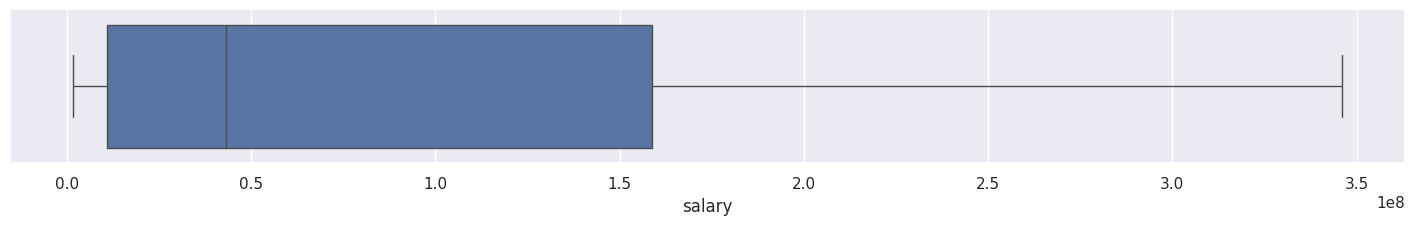

In [224]:
plt.figure(figsize=(18, 2))
sns.boxplot(data_clean['salary'], orient='h');
print ('Всего данных:', data.notnull().sum().sum())

In [225]:
#проверка выбросов в data_clean['salary']
Q1 = data_clean['salary'].quantile(q = .25)
Q3 = data_clean['salary'].quantile(q = .75)
IQR = Q3 - Q1
N_extreme = 3 #N_standart = 1.5

outliers_salary2 = data_clean[~((data_clean['salary'] < (Q3 + N_extreme * IQR)) & (data_clean['salary'] > (Q1 - N_extreme * IQR)))].notnull().sum().sum()
print (f'Выбросов методом межквартильного диапазона:', '\n', outliers_salary2)

Выбросов методом межквартильного диапазона: 
 0.0


In [226]:
#метод._get_numeric_data(), чтобы взять для расчета z-оценок только числовые столбцы
z = np.abs(stats.zscore(data_clean['salary']._get_numeric_data())) #z = (X - μ) / σ
threshold = 3 #пороговое значение для z-score (выбросы = наблюдения с z-показателями> 3 или <-3, не забываем, что, применив abs, мы берем модули значений)

# Keep rows in the dataframe where all z-scores are less than the absolute value of 3
outliers_salary = data_clean['salary'][(z > threshold)]
#find how many rows are left in the dataframe
print (f'Выбросов методом z-оценки:', outliers_salary.notnull().sum(), '\n', outliers_salary.astype('int64'))

Выбросов методом z-оценки: 1 
 id
338    345927135
Name: salary, dtype: int64


In [227]:
#Рассчитываем z-оценку для столбца 'salary'
z_scores = np.abs(stats.zscore(data_clean['salary']))
threshold = 3
#Датасет, где все z-оценки меньше порогового значения
data_clean_salary = data_clean[(z_scores < threshold)]

#Данные после удаления выбросов
print('Размерность данных ДО удаления выбросов:', data_clean.shape, 'после удаления выбросов:', data_clean_salary.shape)

Размерность данных ДО удаления выбросов: (5995, 9) после удаления выбросов: (5994, 9)


In [254]:
#тест на нормальность для столбца 'salary' из data_clean с использованием метода shapiro()
from scipy.stats import shapiro
stat, p_value = shapiro(data_clean_salary['salary'])
α = 0.05
#Вывод результатов теста
print(f'Shapiro-Wilk test: Statistic = {stat}, P-значение = {p_value}', '\n')
if p_value > α:
    print(f'Распределение данных', [data_clean_salary.columns[2]], 'существенно НЕ отличается от нормального.')
else:
    print(f'Распределение данных', [data_clean_salary.columns[2]], 'существенно ОТЛИЧАЕТСЯ от нормального.');

Shapiro-Wilk test: Statistic = 0.8611094710159953, P-значение = 2.0150770715177753e-58 

Распределение данных ['salary'] существенно ОТЛИЧАЕТСЯ от нормального.


###<font color='darkgreen'>
Мы можем воспользоваться непараметрическим тестом Манна-Уитни, так как данные не имеют нормального распределения
</font>

In [229]:
from scipy.stats import mannwhitneyu

#Разделяем данные на две группы: женщины и мужчины
data_women = data_clean_salary[data_clean_salary['sex'] == 0]['salary']
data_men = data_clean_salary[data_clean_salary['sex'] == 1]['salary']
print('Group 0 (women salary mean)', round(data_women.mean(),0),'\n', 'Group 1 (men salary mean)', round(data_men.mean(),0))

Group 0 (women salary mean) 57748625.0 
 Group 1 (men salary mean) 98397184.0


In [230]:
#Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?
if len(data_women) > 0 and len(data_men) > 0:  # Проверка наличия ненулевых выборок
   #тест Манна-Уитни
   statistic, p_value = mannwhitneyu(data_women, data_men, alternative='two-sided')

   print(f'Статистика U Mann-Whitney: = {stat}, P-значение = {p_value}', '\n')
   α = 0.05 / 2 #two-sided
   if p_value < α:
      print("Отвергаем H0: Средние зарплаты у женщин и мужчин различны.")
   else:
      print("Нет оснований отвергнуть H0: Средние зарплаты у женщин и мужчин не различны.")
else:
        print("Одна из выборок пуста, невозможно провести тест")

Статистика U Mann-Whitney: = 0.8611094710159953, P-значение = 1.4376844755838333e-216 

Отвергаем H0: Средние зарплаты у женщин и мужчин различны.


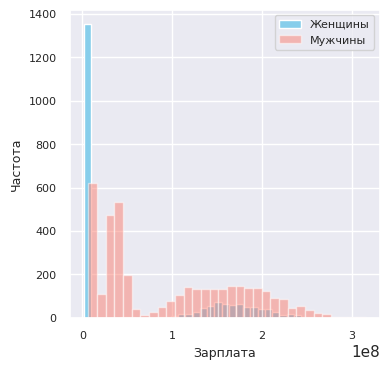

In [231]:
plt.figure(figsize = (4, 4))
plt.hist(data_women, bins = 32, density = False, alpha = 1, color = 'skyblue', label = 'Женщины'); #Выборка A
plt.hist(data_men, bins = 32, density = False, alpha = 0.5, color = 'salmon', label = 'Мужчины');  #Выборка B

plt.xlabel('Зарплата', size = 9)
plt.ylabel('Частота', size = 9)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(labels = ['Женщины','Мужчины'], fontsize = 8);

##<font color='darkblue'>
* 4.Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?
</font>

In [232]:
engineer_salary = data_clean_salary[data_clean_salary['profession'] == 'Engineer']['salary']
entertainment_salary = data_clean_salary[data_clean_salary['profession'] == 'Entertainment']['salary']
engineer_salary.mean() > entertainment_salary.mean()

False

###<font color='darkgreen'>
В формулировке гипотезы явная ошибка, возможно, она должна звучать так:
</font>
#####<font color='darkred'>* Правда ли, что люди из сферы развлечений (Entertainment) зарабатывают в среднем больше, чем инженеры (Engineer)?
</font>

###<font color='darkgreen'>
На визуализации видим все таки нормальное распределение - попробуем для использовать t-test Стьюдента
</font>

In [233]:
#Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?
#Проведение t-теста для сравнения средних значений
t_stat, p_value = stats.ttest_ind(engineer_salary, entertainment_salary, alternative='two-sided')
α = 0.05 / 2 #двухсторнний тест

if p_value < α:
    res = 'Отвергаем H0: Статистические различия есть: Люди из сферы развлечений зарабатывают в среднем больше, чем инженеры.'
else:
    res = 'Принимаем H0: НЕТ статистически значимой разницы.'

print('Значение t-статистики:', t_stat, ' P-значение:', p_value, '\n', res)

Значение t-статистики: -101.09905837222371  P-значение: 0.0 
 Отвергаем H0: Статистические различия есть: Люди из сферы развлечений зарабатывают в среднем больше, чем инженеры.


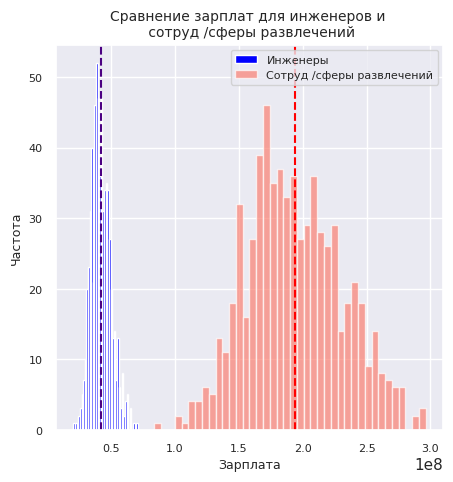

In [234]:
engineer_salary = data_clean_salary[data_clean_salary['profession'] == 'Engineer']['salary']
entertainment_salary = data_clean_salary[data_clean_salary['profession'] == 'Entertainment']['salary']

plt.figure(figsize = (5, 5))
plt.hist(engineer_salary, bins = 40, alpha = 1, color = 'blue', label = 'Инженеры')
plt.hist(entertainment_salary, bins = 40, alpha = 0.7, color = 'salmon', label = 'Сотруд /сферы развлечений')

#Добавление линий для средних значений заработной платы
plt.axvline(x = engineer_salary.mean(), color = 'indigo', linestyle = 'dashed', linewidth = 1.5)
plt.axvline(x = entertainment_salary.mean(), color = 'red', linestyle = 'dashed', linewidth = 1.5)

plt.xlabel('Зарплата', size = 9)
plt.ylabel('Частота', size = 9)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title('Сравнение зарплат для инженеров и \n сотруд /сферы развлечений', fontsize = 10)
plt.legend(labels = ['Инженеры','Сотруд /сферы развлечений'], fontsize = 8);

##<font color='darkblue'>
* 5.Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?
</font>

In [235]:
#Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?
#данные для групп с разным количеством детей
data_clean_salary.loc[:, 'children'] = data_clean_salary['children'].astype(int) #подкорректируем вывод целых чисел (без нолей после запятой) в колонке дети
data_clean_salary_groupby3 = data_clean_salary.groupby(['children']).agg(Mean_salary = ('salary','mean'), Median_salary = ('salary','median'), Count = ('salary','count'))

more_than_three_children_salary = data_clean_salary_groupby3.loc[data_clean_salary_groupby3.index > 3]['Mean_salary'] #Сред. зарплата людей с более чем 3 д-ми
less_or_three_children_salary = data_clean_salary_groupby3.loc[data_clean_salary_groupby3.index <= 3]['Mean_salary'] #Сред. зарплата людей менее чем или равным 3 детям

#тест Манна-Уитни для сравнения средних значений
stat, p_value = mannwhitneyu(more_than_three_children_salary, less_or_three_children_salary)
α = 0.05

print('Статистика U Mann-Whitneyu:', stat, ' P-значение:', p_value)

if p_value < α:
    print('Отвергаем H0: Существует статистически значимая разница.')
else:
    print('Принимаем H0: Нет статистически значимой разницы.');

Статистика U Mann-Whitneyu: 9.0  P-значение: 0.4
Принимаем H0: Нет статистически значимой разницы.


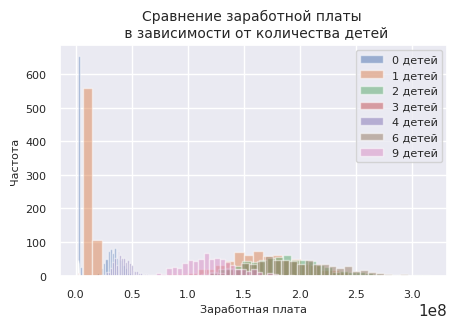

In [236]:
plt.figure(figsize=(5, 3))
for children_count in data_clean_salary_groupby3.index:
    salary_val = data_clean_salary[data_clean_salary['children'] == children_count]['salary']
    plt.hist(salary_val, bins=30, density = False, alpha=0.5, label=f'{children_count} детей')

plt.xlabel('Заработная плата', size = 8)
plt.ylabel('Частота', size = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title('Сравнение заработной платы \n в зависимости от количества детей', size = 10)
plt.legend(fontsize = 8);

##<font color='darkblue'>
* 6.Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?
</font>

###<font color='darkgreen'>
Проанализируем данные столбца 'home_cost' на выбросы, удалим их и проверим распределение данных столбца на нормальность.
</font>

Всего данных: 51230


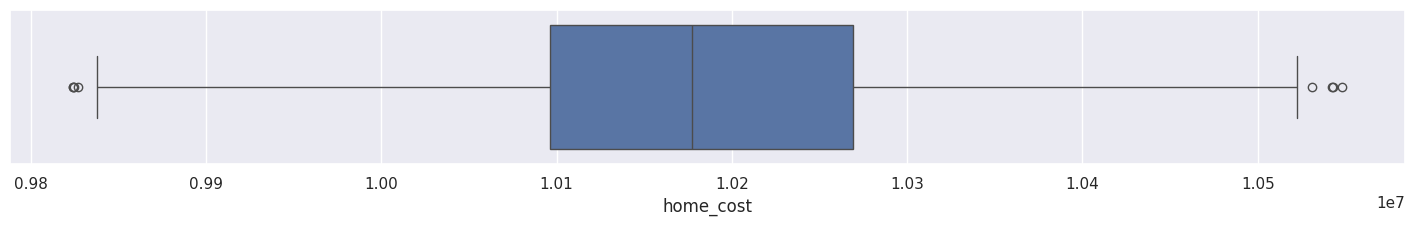

In [237]:
plt.figure(figsize=(18, 2))
sns.boxplot(data_clean['home_cost'], orient='h');
print ('Всего данных:', data.notnull().sum().sum())

In [238]:
#метод._get_numeric_data(), чтобы взять для расчета z-оценок только числовые столбцы
z = np.abs(stats.zscore(data_clean['home_cost']._get_numeric_data())) #z = (X - μ) / σ
threshold = 3 #пороговое значение для z-score (выбросы = наблюдения с z-показателями> 3 или <-3, не забываем, что, применив abs, мы берем модули значений)

#датафрейм где все z-оценки меньше порогового значения 3
outliers_home_cost = data_clean['home_cost'][(z > threshold)]
#вывод кол-ва потерь
print (f'Выбросов методом z-оценки:', outliers_home_cost.notnull().sum(), '\n', outliers_home_cost.astype('int64'))

Выбросов методом z-оценки: 6 
 id
173      9824378
714     10542132
1825    10547794
2070     9824840
3912    10543112
173      9824378
Name: home_cost, dtype: int64


In [239]:
#рассчитываем z-оценки для столбца 'home_cost'
z_scores = np.abs(stats.zscore(data_clean['home_cost']))
threshold = 3
#выбираем строки, где все z-оценки меньше порогового значения
data_clean_home_cost = data_clean[(z_scores < threshold)]

#информация о данных после удаления выбросов
print('Размерность данных ДО удаления выбросов:', data_clean.shape, 'после удаления выбросов:', data_clean_home_cost.shape)

Размерность данных ДО удаления выбросов: (5995, 9) после удаления выбросов: (5989, 9)


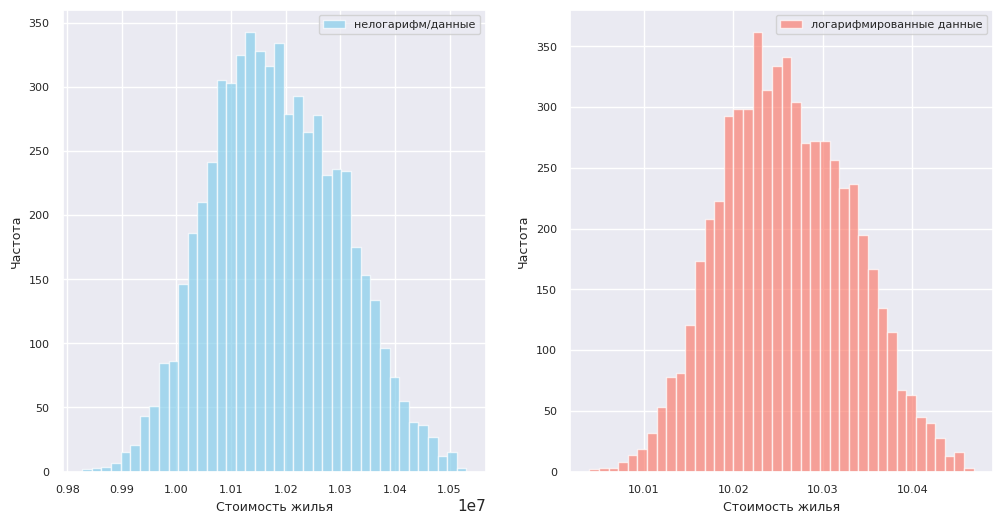

In [240]:
data_h_c_log = data_clean_home_cost.copy()
#пытаемся логарифмируовать числовые признаки
numerical_features = data_h_c_log.select_dtypes(include = [np.number]).columns
data_h_c_log[numerical_features] = np.log(data_h_c_log[numerical_features] + 1)  / np.log(5)  #+1 (если есть 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#график 1 - нелогарифмированные данные
ax1.hist(data_clean_home_cost['home_cost'], bins=40, density=False, alpha=0.7, color='skyblue', label='нелогарифм/данные')
ax1.set_xlabel('Стоимость жилья', size=9)
ax1.set_ylabel('Частота', size=9)
ax1.tick_params(labelsize=8)
ax1.legend(fontsize=8)

#график 2 - логарифмированные данные
ax2.hist(data_h_c_log['home_cost'], bins=40, density=False, alpha=0.7, color='salmon', label='логарифмированные данные')
ax2.set_xlabel('Стоимость жилья', size=9)
ax2.set_ylabel('Частота', size=9)
ax2.tick_params(labelsize=8)
ax2.legend(fontsize=8)

plt.show()

In [241]:
#тест на нормальность для столбца 'homecost' из data_clean с использованием метода shapiro()
from scipy.stats import shapiro
stat, p_value = shapiro(data_clean_home_cost['home_cost'])
α = 0.05
print(f'Shapiro-Wilk test: Статистик = {stat}, P-значение = {p_value}', '\n')
if p_value > α:
    print(f'Распределение данных', [data_clean_home_cost.columns[6]], 'НЕ отличается от нормального.')
else:
    print(f'Распределение данных', [data_clean_home_cost.columns[6]], 'ОТЛИЧАЕТСЯ от нормального.');

Shapiro-Wilk test: Статистик = 0.9949234183379544, P-значение = 1.0769005238846522e-13 

Распределение данных ['home_cost'] ОТЛИЧАЕТСЯ от нормального.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5989.
  res = hypotest_fun_out(*samples, **kwds)



###<font color='darkgreen'>
На визуализации видим все таки нормальное распределение -  попробуем для использовать t-test Стьюдента
</font>

In [242]:
#Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?
artist_home_cost = data_clean_home_cost[data_clean_home_cost['profession'] == 'Artist']['home_cost']
lawyer_home_cost = data_clean_home_cost[data_clean_home_cost['profession'] == 'Lawyer']['home_cost']

#проведение t-теста для сравнения средних значений
t_stat, p_value = stats.ttest_ind(engineer_salary, lawyer_home_cost, alternative = 'two-sided')
α = 0.05 / 2 #двухсторонний тест

if p_value < α:
    res = ("Отвергаем H0: Средние стоимости домов художников (Artist) и адвокатов (Lawyer) различны.")
else:
    res = ("Нет оснований отвергнуть H0: Статистических различий в стоимости домов  художников (Artist) и адвокатов (Lawyer) не найдено.")

print('Значение t-статистики:', t_stat, ' P-значение:', p_value, '\n', res)

Значение t-статистики: 106.22545337334354  P-значение: 0.0 
 Отвергаем H0: Средние стоимости домов художников (Artist) и адвокатов (Lawyer) различны.


In [243]:
print(f'{round(artist_home_cost.mean(),0)}, {round(lawyer_home_cost.mean(), 0)}, {artist_home_cost.mean() > lawyer_home_cost.mean()}')

10223854.0, 10272115.0, False


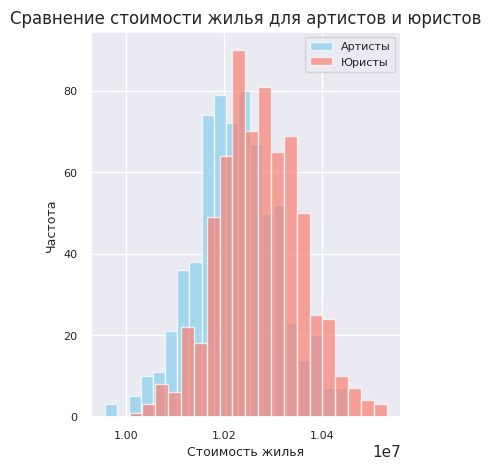

In [244]:
plt.figure(figsize=(4, 5))
plt.hist(artist_home_cost, bins=20, alpha=0.7, color='skyblue', label = 'Артисты')
plt.hist(lawyer_home_cost, bins=20, alpha=0.7, color='salmon', label = 'Юристы')

plt.xlabel('Стоимость жилья', size = 9)
plt.ylabel('Частота', size = 9)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title('Сравнение стоимости жилья для артистов и юристов')
plt.legend(labels = ['Артисты','Юристы'], fontsize = 8);

##<font color='darkblue'>
* 7.Правда ли, что недвижимость у тех, кто когда либо был в браке в среднем дороже, чем у тех, кто никогда не был в браке?
</font>


In [245]:
#группы по признаку был в браке / не был в браке
data_married = data_clean_salary.loc[data_clean_salary['was_married'] == 1, 'home_cost']
data_single = data_clean_salary.loc[data_clean_salary['was_married'] == 0, 'home_cost']

stats_married = (data_married.mean(), data_married.median())
stats_single = (data_single.mean(), data_single.median())
print(f"Статистика тех, кто был в браке: среднее - {round(stats_married[0],0)}, медиана - {round(stats_married[1],0)}")
print(f"Статистика тех, кто не был в браке: среднее - {round(stats_single[0],0)}, медиана - {round(stats_single[1],0)}")

Статистика тех, кто был в браке: среднее - 10165926.0, медиана - 10155673.0
Статистика тех, кто не был в браке: среднее - 10277031.0, медиана - 10276784.0


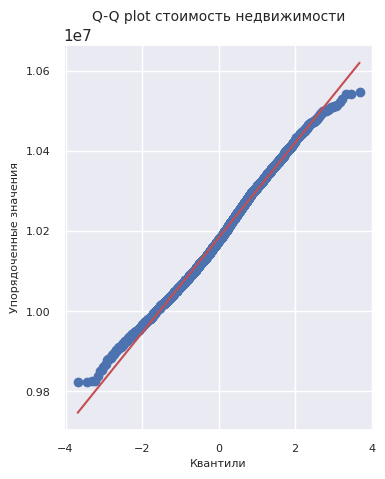

In [246]:
# Построение квантильной диаграммы (Q-Q plot)
plt.figure(figsize=(4, 5))
stats.probplot(data_clean_salary['home_cost'], dist="norm", plot=plt)
plt.title('Q-Q plot стоимость недвижимости', fontsize = 10)
plt.xlabel('Квантили', size = 8)
plt.ylabel('Упорядоченные значения', size = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.tight_layout;

###<font color='darkgreen'>
На визуализации видим все таки нормальное распределение -  попробуем для использовать t-test Стьюдента
</font>

Значение t-статистики: -28.1089933491683  P-значение: 0.0 
 Отвергаем H0: Недвижимость у тех, кто когда-либо был в браке в среднем дороже, чем у тех, кто никогда не был в браке. 

0.0


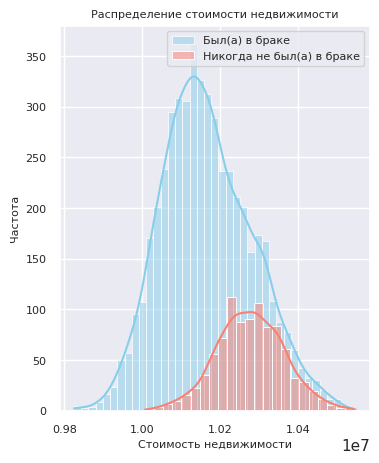

In [247]:
#правда ли, что недвижимость у тех, кто когда-либо был в браке в среднем дороже, чем у тех, кто никогда не был в браке?
# t-тест Стьюдента
t_stat, p_val = stats.ttest_ind(data_married, data_single, alternative='two-sided')
α = 0.05 / 2 #двухсторнний тест
if p_value < α:
    res = ("Отвергаем H0: Недвижимость у тех, кто когда-либо был в браке в среднем дороже, чем у тех, кто никогда не был в браке.")
else:
    res = ("Нет оснований отвергнуть H0: Статистических различий в стоимости недвижимости тех, кто был в браке и тех, кто не был в браке НЕ НАЙДЕНО.")

print('Значение t-статистики:', t_stat, ' P-значение:', p_value, '\n', res, '\n')
print(p_value)

#гистограмма с наложенными 2 группами
plt.figure(figsize=(4, 5))
sns.histplot(data_married, kde=True, color='skyblue', label='Был(а) в браке')
sns.histplot(data_single, kde=True, color='salmon', label='Никогда не был(а) в браке')

#график по t-тесту
plt.title(f'Распределение стоимости недвижимости', fontsize=8)
plt.xlabel('Стоимость недвижимости', fontsize=8)
plt.ylabel('Частота', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8);

##<font color='darkblue'>
* 8.Правда ли, что мужчины в среднем чаще бывают в браке, чем женщины?
</font>

**Подсказка** - Составьте матрицу смежности и воспользуйтесь критерием хи-квадрат из библиотеки scipy

In [248]:
# Заменяем числовые значения на категории "женщины" и "мужчины", "в браке" и "не в браке"
data_clean_small2 = data_clean_small.copy()
data_clean_small2['sex'] = data_clean_small2['sex'].map({0: 'female', 1: 'male'}) #map применяет к каждому элементу
data_clean_small2['was_married'] = data_clean_small2['was_married'].map({0: 'Not married', 1: 'Married'})

# матрица смежности
matrix = pd.crosstab(data_clean_small2['sex'], data_clean_small2['was_married'])
matrix

was_married,Married,Not married
sex,,
female,1358,670
male,3689,278


In [249]:
#Правда ли, что мужчины в среднем чаще бывают в браке, чем женщины?
from scipy.stats import chi2_contingency
# тест Хи-квадрат
chi2, p, dof, expected = chi2_contingency(matrix)
α = 0.05

if p < α:
    res = "Отвергаем H0: Существует статистически значимая разница, мужчины в среднем чаще бывают в браке, чем женщины."
else:
    res = "Принимаем H0: Нет статистически значимой разницы."

print("P-Value:", p)
print(res)

P-Value: 3.97625859922564e-150
Отвергаем H0: Существует статистически значимая разница, мужчины в среднем чаще бывают в браке, чем женщины.


<Figure size 400x300 with 0 Axes>

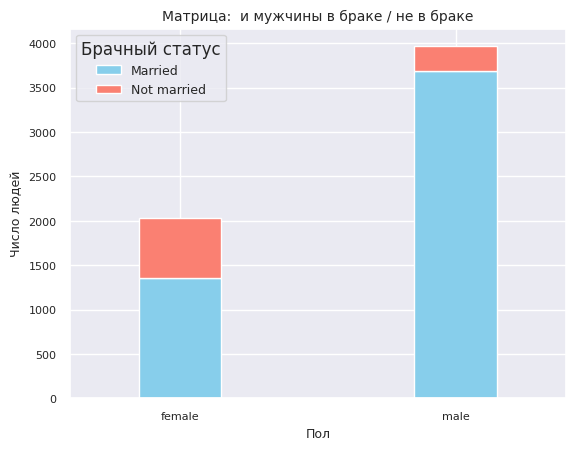

In [250]:
plt.figure(figsize = (4, 3))
matrix.plot(kind = 'bar', stacked = True, color = ['skyblue', 'salmon'], width=0.3)
plt.title('Матрица:  и мужчины в браке / не в браке', fontsize = 10)
plt.xlabel('Пол', size = 9)
plt.ylabel('Число людей', size = 9)
plt.xticks(fontsize = 8, rotation = 0)  #plt.xticks([0, 1], ['Женщины', 'Мужчины'], fontsize = 8, rotation = 0)
plt.yticks(fontsize = 8)
plt.legend(title = 'Брачный статус', fontsize = 9);


##<font color='darkblue'>
* 9.Правда ли, что женщины с зарплатой выше медианной в среднем более счастливые, чем мужчины с зарплатой, которая выше средней?
</font>

In [251]:
median_salary = data_clean_small['salary'].median()
mean_salary = data_clean_small['salary'].mean()
#данные для выбора женщин с зарплатой выше медианы + построчная добавка уровня счастья
women_median_salary_plus = data_clean_small[(data_clean_small['sex'] == 0) & (data_clean_small['salary'] > median_salary)]['happyness']
#данные для выбора мужчин с зарплатой выше среднего + построчная добавка уровня счастья
men_mean_salary_plus = data_clean_small[(data_clean_small['sex'] == 1) & (data_clean_small['salary'] > mean_salary)]['happyness']

#тест Манна-Уитни (распределение данных ['salary'] существенно ОТЛИЧАЕТСЯ от нормального)
statistic, p_value = mannwhitneyu(women_median_salary_plus, men_mean_salary_plus, alternative='two-sided')
α = 0.05 / 2 #двухсторнний тест

if p_value < α:
    res = "Отвергаем H0: Женщины с зарплатой выше медианной в среднем более счастливые, чем мужчины с зарплатой, которая выше средней."
else:
    res = "Принимаем H0: НЕТ статистически значимой разницы."

print('Statistic:', statistic, 'P-Value:', p_value)
print(res)

Statistic: 148936.0 P-Value: 2.8662641562535153e-198
Отвергаем H0: Женщины с зарплатой выше медианной в среднем более счастливые, чем мужчины с зарплатой, которая выше средней.


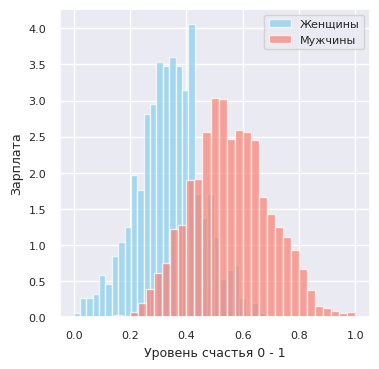

In [252]:
plt.figure(figsize = (4, 4))
plt.hist(women_median_salary_plus, bins = 30, density = True, alpha = 0.7, color = 'skyblue', label = 'Женщины'); #Выборка A
plt.hist(men_mean_salary_plus, bins = 30, density = True, alpha = 0.7, color = 'salmon', label = 'Мужчины');  #Выборка B

plt.xlabel('Уровень счастья 0 - 1', size = 9)
plt.ylabel('Зарплата', size = 9)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(labels = ['Женщины','Мужчины'], fontsize = 8);